In [93]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
# remove white grid lines
mpl.rc('axes', grid=False)
# turn off colorblind mode
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

In [94]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import trackpy as tp


### Step 1: Read the Video/Image Data

Using PIMS, trackpy can read:

- a directory or zipfile of sequential images
- a multi-frame TIFF file
- a video (AVI, MOV, etc.)
- specialty formats used in microscopy and scientific video capture:
- Cine, NorPix seq
- LSM
- Files supported by Bioformats
- ND2 using PIMS_ND2

(Some of the formats require some extra dependencies. For a complete list, see the README page for PIMS, or the installation instructions in the documentation.)

For many formats, using pims.open just works. Since these images are in color, we also need to set up a pipeline to convert each image to grayscale when it is read

In [95]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel


frames_2 = gray(pims.PyAVVideoReader(r'C:\Users\nohor3086\Desktop\Paper Particle Recordings\recording_20250805_110400.avi'))
frames_1 = gray(pims.PyAVVideoReader(r'C:\Users\nohor3086\Desktop\Paper Particle Recordings\recording_20250731_104824.avi'))
frames_0 = gray(pims.PyAVVideoReader(r'C:\Users\nohor3086\Desktop\Paper Particle Recordings\recording_20250731_135919.avi'))

f2 = tp.locate(frames_2[0], 13, invert=False)
f1 = tp.locate(frames_1[0], 13, invert=False)
f0 = tp.locate(frames_0[0], 13, invert=False)



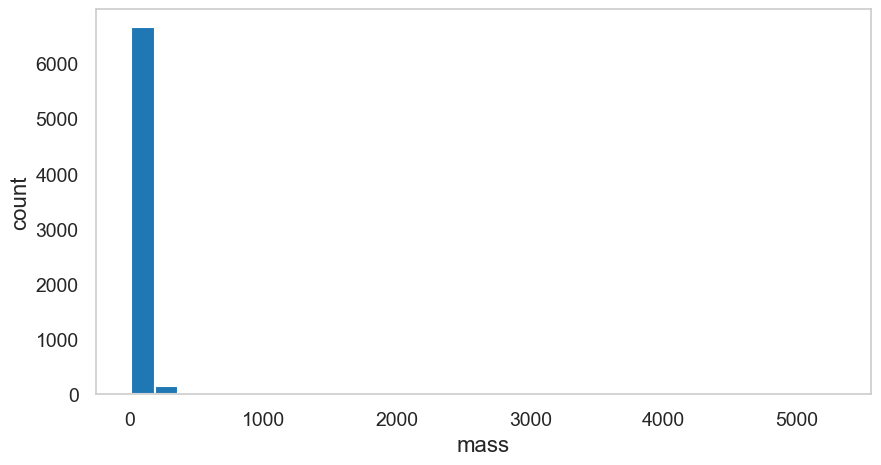

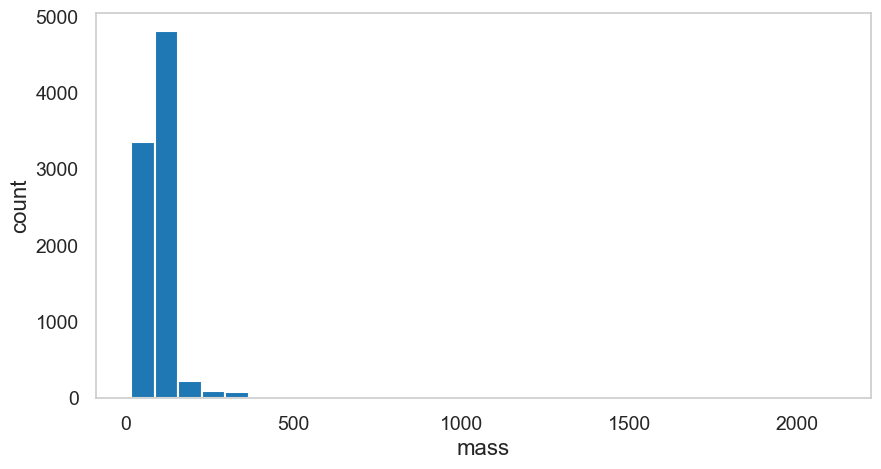

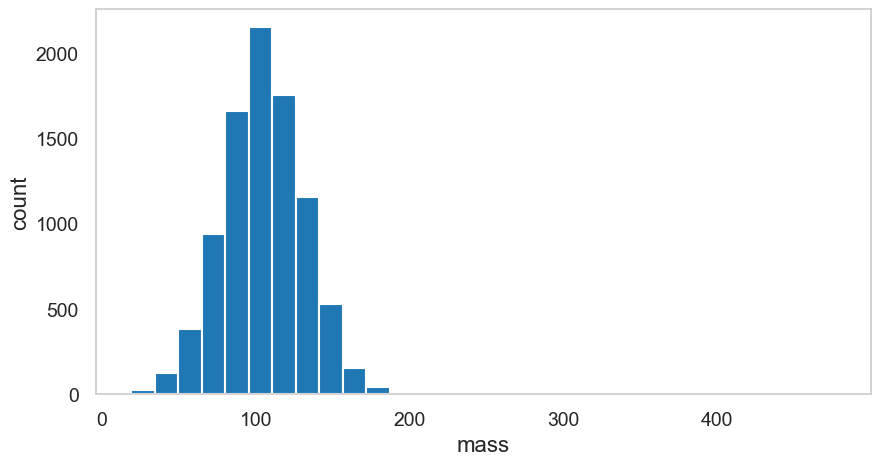

In [96]:
fig, ax = plt.subplots()
ax.hist(f2['mass'], bins=30)
# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');
plt.show()
fig, ax = plt.subplots()
ax.hist(f1['mass'], bins=30)
# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');
plt.show()
fig, ax = plt.subplots()
ax.hist(f0['mass'], bins=30)
# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');
plt.show()

### Step 2: Cleaning up the Data

Now we see that a grand portion of these particles have a very small average brightness (mass) so we threshold them out.


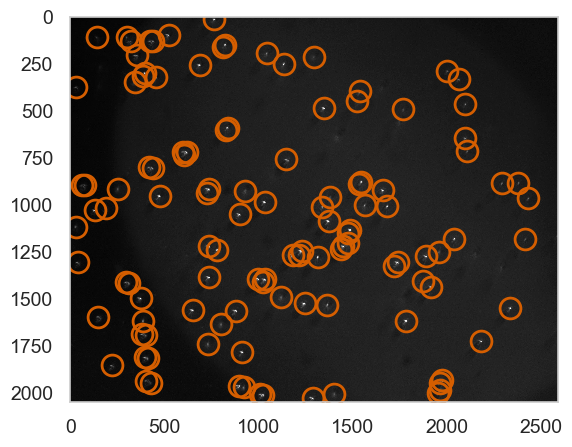

C:\Users\nohor3086\AppData\Roaming\Python\Python312\site-packages\trackpy\plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


2146


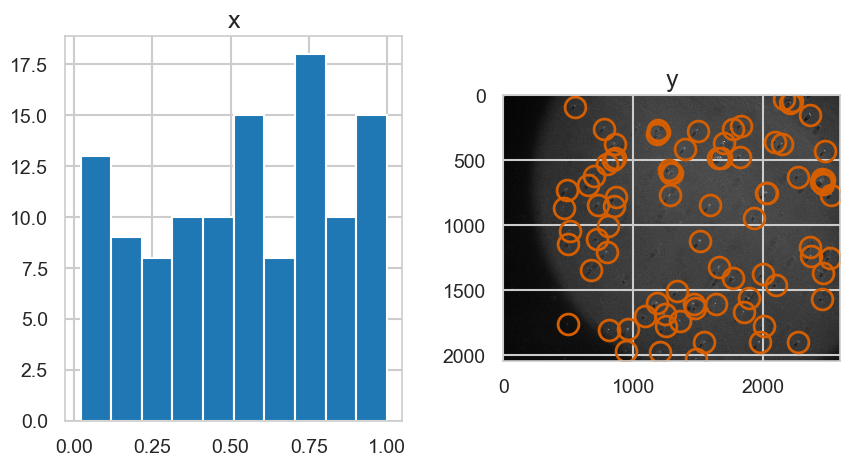

C:\Users\nohor3086\AppData\Roaming\Python\Python312\site-packages\trackpy\plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


2146


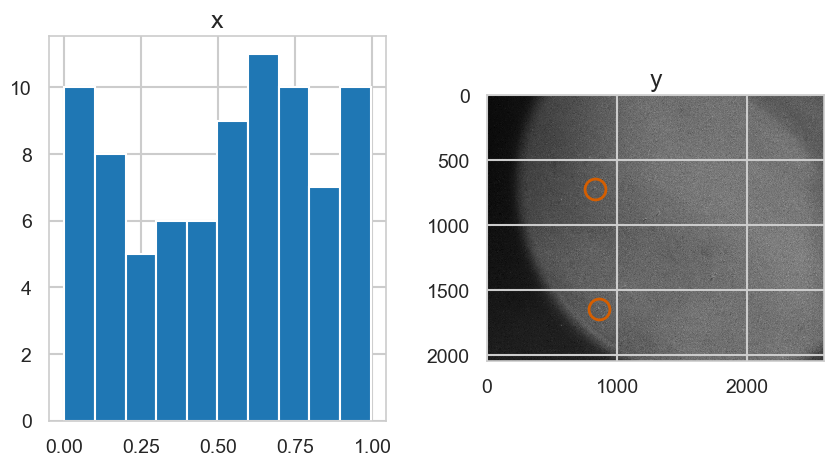

2146


C:\Users\nohor3086\AppData\Roaming\Python\Python312\site-packages\trackpy\plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
3304,718.639129,829.920448,507.797757,3.484257,0.091458,11.319908,8527.0,0.026849,1
7639,1641.677744,859.251745,559.691767,3.647989,0.090210,9.677412,8776.0,0.025350,1


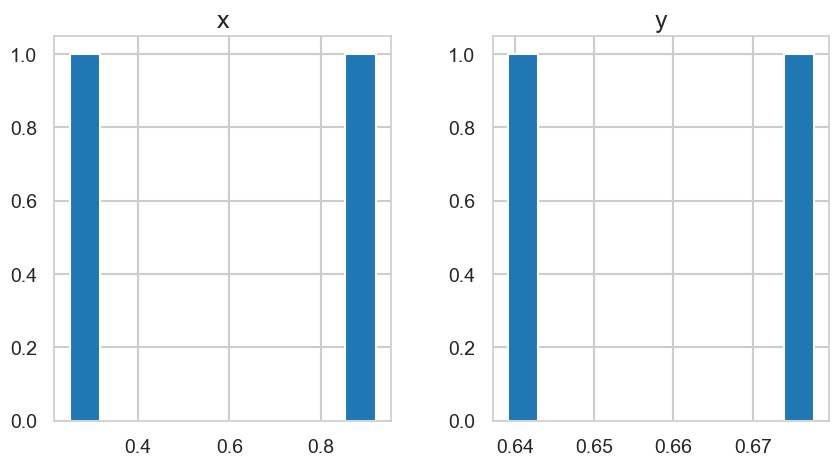

In [97]:

f_thresholded = tp.locate(frames_2[1], diameter=13, invert=False, minmass=500)
tp.annotate(f_thresholded, frames_2[1])

# Check subpixel bias
tp.subpx_bias(f_thresholded)
print(len(frames_2))
f_thresholded


f_thresholded = tp.locate(frames_1[1], diameter=13, invert=False, minmass=500)
tp.annotate(f_thresholded, frames_1[1])

# Check subpixel bias
tp.subpx_bias(f_thresholded)
print(len(frames_2))
f_thresholded


f_thresholded = tp.locate(frames_0[1], diameter=13, invert=False, minmass=500)
tp.annotate(f_thresholded, frames_0[1])

# Check subpixel bias
tp.subpx_bias(f_thresholded)
print(len(frames_2))
f_thresholded


# Step 3: Locate features in all frames
We do this by using a new function, the batch function trackpy.batch()

In [98]:
# to speed up the calculations we can turn off the verbose nature of the function to remove prints
tp.quiet(suppress=False)
# frames = list(frames)  # load all frames into RAM
f_batch_2 = tp.batch(frames_2, 13, minmass=500, invert = False, processes=4)
f_batch_1 = tp.batch(frames_1, 13, minmass=450, invert = False, processes=4)
f_batch_0 = tp.batch(frames_0, 11, minmass=200, invert = False, processes=4)

Frame 1819: 23 features


# Step 4: Link the gathered trajectories 

We have the locations of the particles in each frame. Next we'll track particles from frame to frame, giving each one a number for identification.

First, we must must specify a maximum displacement, the farthest a particle can travel between frames. We should choose the smallest reasonable value because a large value slows computation time considerably. In this case, 5 pixels is reasonable.

Second, we allow for the possibility that a particle might be missed for a few frames and then seen again. (Perhaps its "mass" slipped below our cutoff due to noise in the video.) Memory keeps track of disappeared particles and maintains their ID for up to some number of frames after their last appearance. Here we use 3 frames.

Frame 2145: 151 trajectories present.


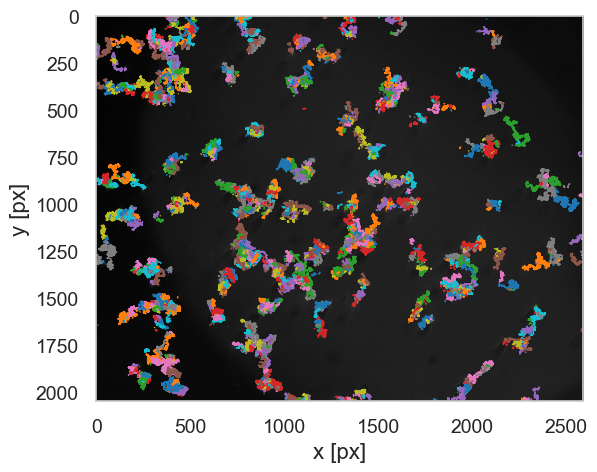

In [99]:
trajectories_2  = tp.link(f_batch_2, search_range=20, memory=30)
trajectories_2.head()
plt.figure()
tp.plot_traj(trajectories_2, superimpose=frames_2[0])
plt.show()

Frame 2023: 84 trajectories present.


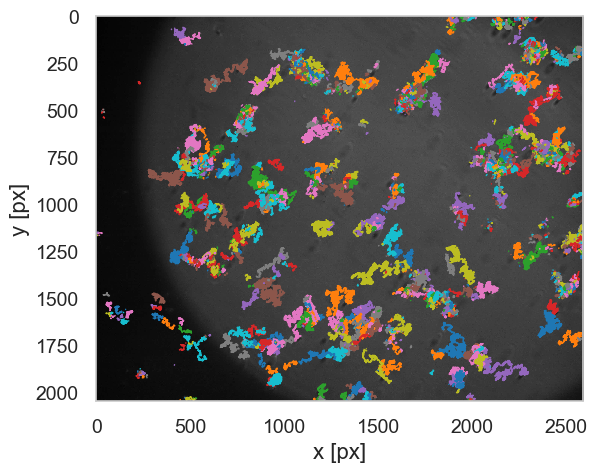

In [100]:

trajectories_1  = tp.link(f_batch_1, search_range=20, memory=20)
trajectories_1.head()
plt.figure()
tp.plot_traj(trajectories_1, superimpose=frames_1[0])
plt.show()



Frame 1819: 23 trajectories present.


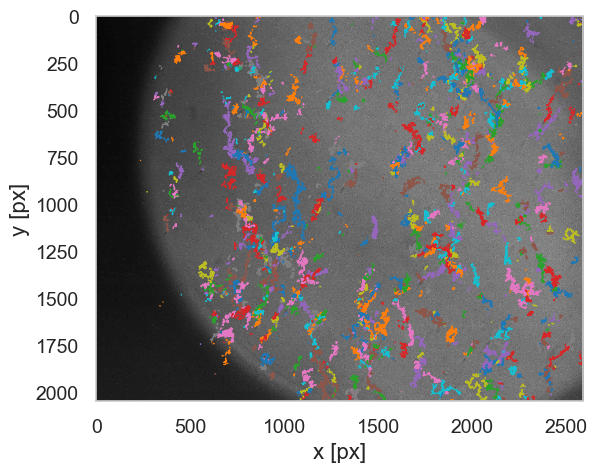

In [101]:

trajectories_0  = tp.link(f_batch_0, search_range=20, memory=30)
trajectories_0.head()
plt.figure()
tp.plot_traj(trajectories_0, superimpose=frames_0[0])
plt.show()

# Step 5: Filter out stub/ephemeral trajectories

We filter out stub trajectories through the use of the trackpy.filter_stubs() functionality, where we pass in a minimum length required for all kept trajectories. In this case, we use 25 frames.

In [117]:
t1_2 = tp.filter_stubs(trajectories_2, 100)
# Compare the number of particles in the filtered and filtered data.
print('Before:', trajectories_2['particle'].nunique())
print('After:', t1_2['particle'].nunique())

t1_1 = tp.filter_stubs(trajectories_1, 100)
# Compare the number of particles in the filtered and filtered data.
print('Before:', trajectories_1['particle'].nunique())
print('After:', t1_1['particle'].nunique())

t1_0 = tp.filter_stubs(trajectories_0, 100)
# Compare the number of particles in the filtered and filtered data.
print('Before:', trajectories_0['particle'].nunique())
print('After:', t1_0['particle'].nunique())

Before: 1600
After: 473
Before: 1941
After: 358
Before: 1382
After: 167
Before: 1941
After: 358
Before: 1382
After: 167


From these kinds of diagrams we can figure out which features are likely undesirable, and if there is a large variation in what we wish to detect. If there is something that we would like to remove, then we can simply filter it out using pandas dataframe modification.

## Step 8: Remove any flows/drifts present outside of Brownian Motion

Some pretty significant linear pixel drift to be taken out.

In [118]:
d_2 = tp.compute_drift(t1_2)
d_1 = tp.compute_drift(t1_1)
d_0 = tp.compute_drift(t1_0)

tm_2 = tp.subtract_drift(t1_2.copy(), d_2)

tm_1 = tp.subtract_drift(t1_1.copy(), d_1)

tm_0 = tp.subtract_drift(t1_0.copy(), d_0)

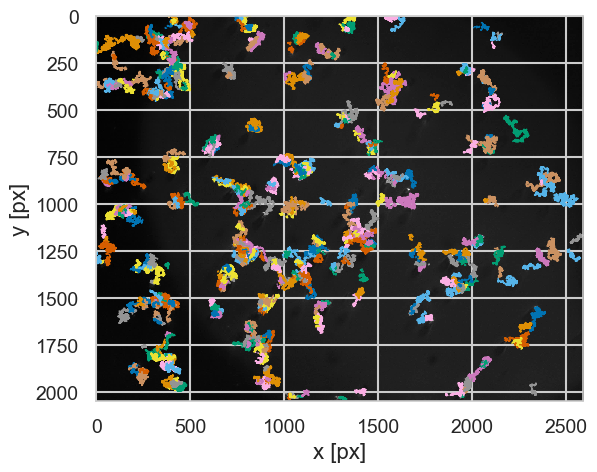

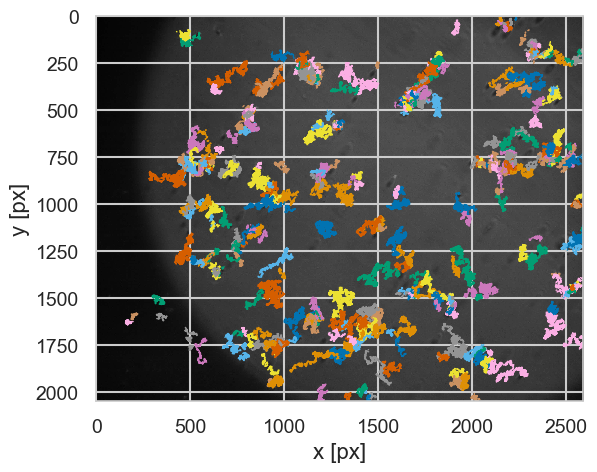

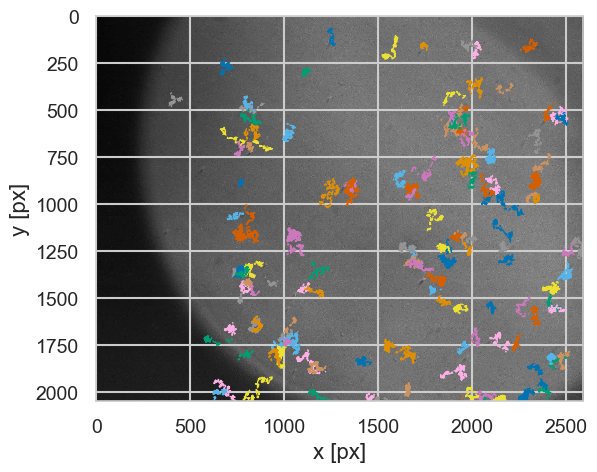

In [119]:
ax = tp.plot_traj(tm_2, superimpose=frames_2[0])
plt.show()

ax = tp.plot_traj(tm_1, superimpose=frames_1[0])
plt.show()

ax = tp.plot_traj(tm_0, superimpose=frames_0[0])
plt.show()

## Step 9: Analyze measured Brownian Motion

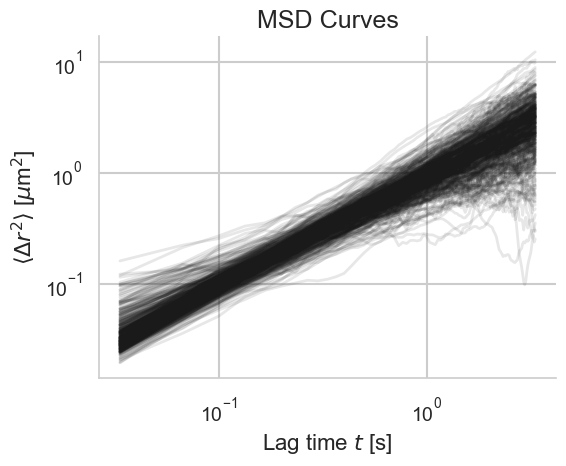

Inv-Gamma Parameters: shape=7.796, loc=0.000, scale=7.335
Mean radius (from fit): 1.079 µm
Mean Radius (from data): 1.079 µm
Radius Variance (from fit): 0.201 µm²
Radius Variance (from data): 0.194 µm²


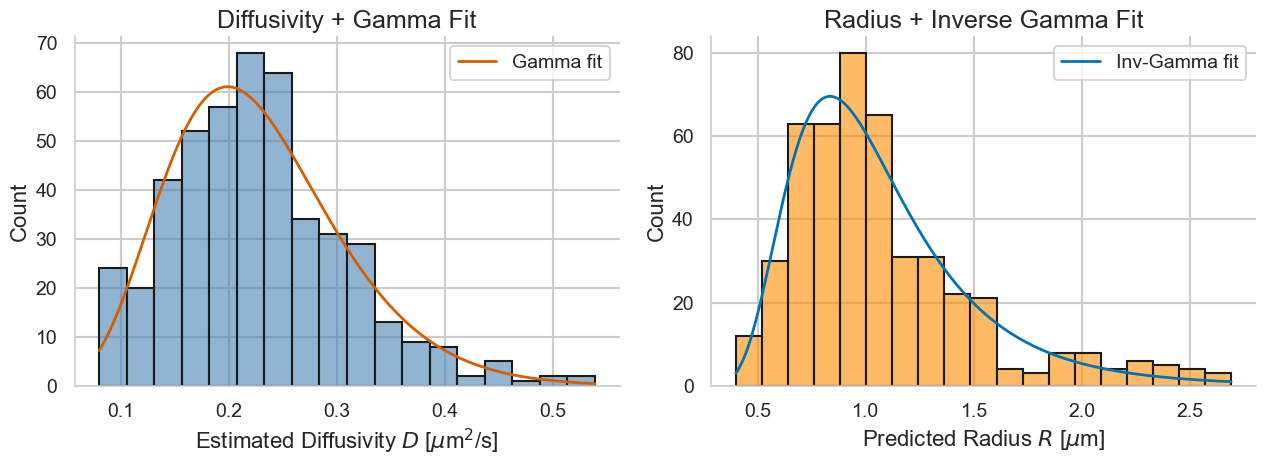

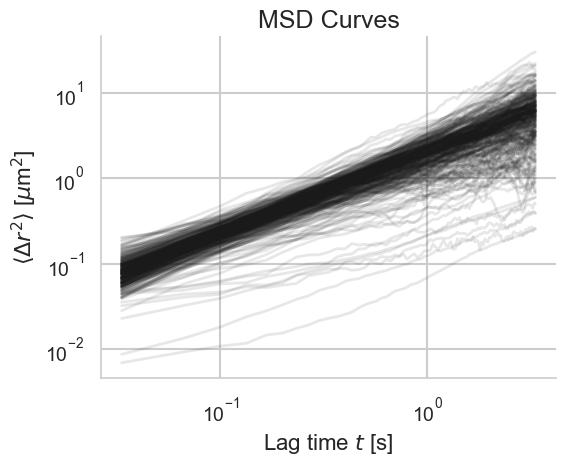

Inv-Gamma Parameters: shape=4.557, loc=0.000, scale=2.094
Mean radius (from fit): 0.589 µm
Mean Radius (from data): 0.614 µm
Radius Variance (from fit): 0.136 µm²
Radius Variance (from data): 0.276 µm²


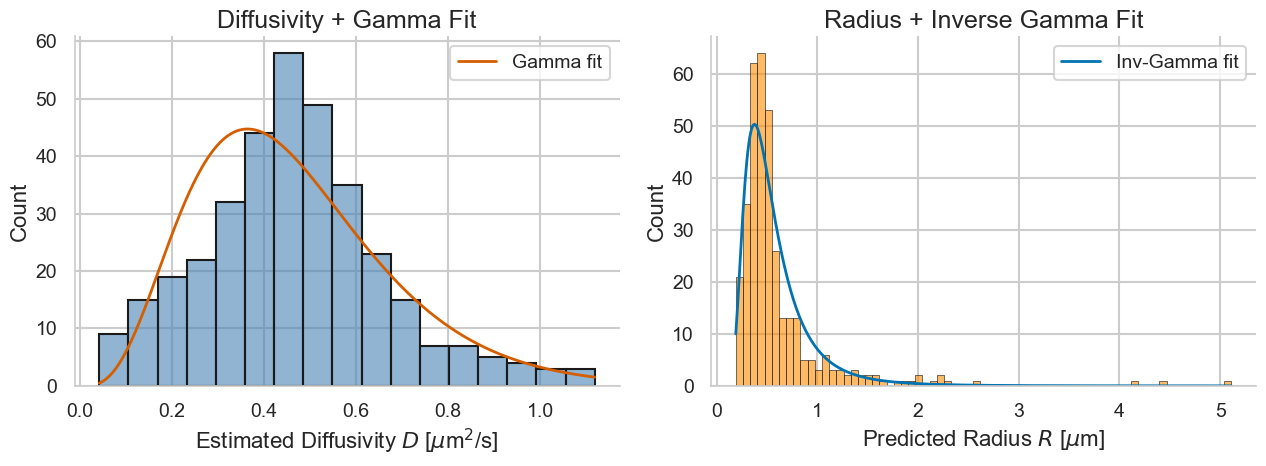

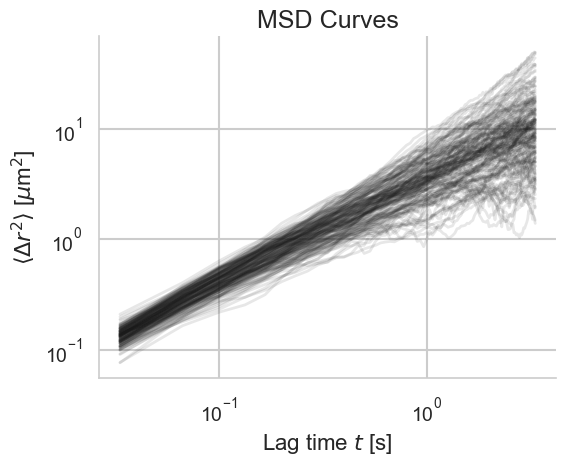

Inv-Gamma Parameters: shape=4.390, loc=0.000, scale=0.994
Mean radius (from fit): 0.293 µm
Mean Radius (from data): 0.287 µm
Radius Variance (from fit): 0.036 µm²
Radius Variance (from data): 0.021 µm²


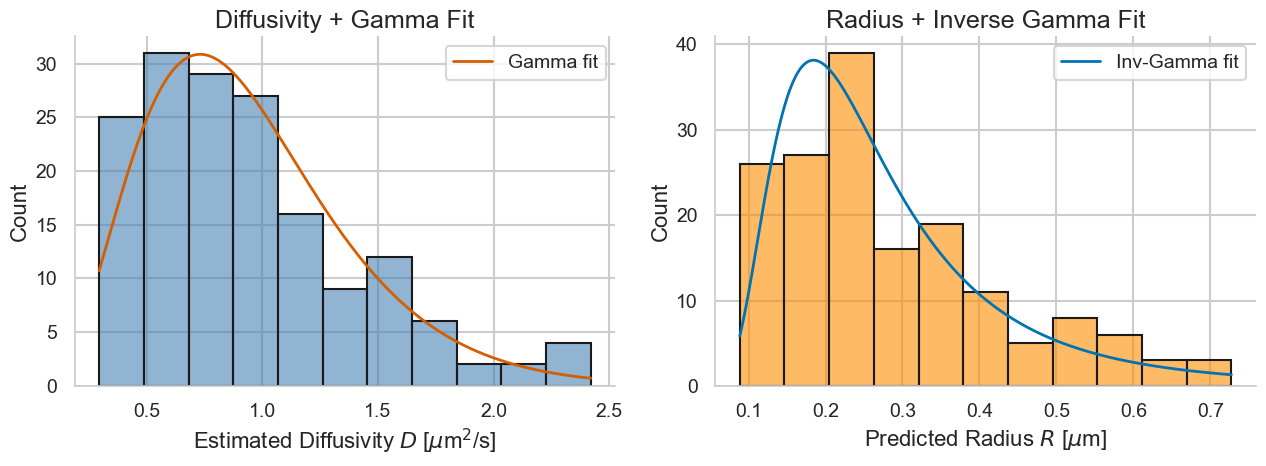

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma, invgamma
import trackpy as tp

# --- Aesthetic settings ---
sns.set_theme(style='whitegrid', context='talk', palette='colorblind')
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'lines.linewidth': 2,
    'axes.linewidth': 1.2,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# --- MSD Analysis ---
for tm_i in [tm_2, tm_1, tm_0]:
    tm = tm_i.reset_index(drop=True)

    # First filter out low-MSD tracks using 100 lag
    im_long = tp.imsd(tm, 0.0728, 30, 100)
    particles_with_zero_msd = im_long.columns[(im_long <= 0.001).any(axis=0)]
    tm = tm[~tm['particle'].isin(particles_with_zero_msd)]

    # Compute MSDs with shorter window
    im = tp.imsd(tm, 0.0728, 30, 100)

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(im.index, im, 'k-', alpha=0.1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Lag time $t$ [s]')
    ax.set_ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
    ax.set_title('MSD Curves')
    sns.despine()
    plt.tight_layout()
    plt.show()

    # --- Diffusivity and Radius ---
    k_B = 1.380649e-23  
    T = 293.15          
    eta = 1.002e-3       
    lag_time = im.index[51]  # Use 1 frame lag time
    msd_at_1 = im.loc[lag_time]
    msd_at_1 = msd_at_1[msd_at_1 > 0]

    d = 2
    D = msd_at_1 / (2 * d * lag_time)           
    D_m2_per_s = D * 1e-12                     
    R_m = k_B * T / (6 * np.pi * eta * D_m2_per_s)
    R_um = R_m * 1e6                            

    D_vals = D.to_numpy()
    R_vals = R_um.to_numpy()

    # --- Filter to middle 99% (e.g., 0.5%–99.5%) ---
    def filter_middle_99(data):
        lower, upper = np.percentile(data, [1, 99])
        return data[(data >= lower) & (data <= upper)]

    D_vals_filt = filter_middle_99(D_vals)
    R_vals_filt = filter_middle_99(R_vals)

    # --- Bin Estimation ---
    def freedman_diaconis_bins(data):
        q25, q75 = np.percentile(data, [25, 75])
        iqr = q75 - q25
        bin_width = 2 * iqr / (len(data)**(1/3))
        return max(int(np.ceil((data.max() - data.min()) / bin_width)), 5)

    n_bins_D = freedman_diaconis_bins(D_vals_filt)
    n_bins_R = freedman_diaconis_bins(R_vals_filt)

    bin_edges_D = np.histogram_bin_edges(D_vals_filt, bins=n_bins_D)
    bin_edges_R = np.histogram_bin_edges(R_vals_filt, bins=n_bins_R)

    # --- Fit Distributions on Filtered Data ---
    gamma_shape, gamma_loc, gamma_scale = gamma.fit(D_vals_filt, floc=0)
    inv_gamma_shape, inv_gamma_loc, inv_gamma_scale = invgamma.fit(R_vals_filt, floc=0)

    # --- Generate Smooth PDF Curves ---
    x_smooth_D = np.linspace(D_vals_filt.min(), D_vals_filt.max(), 500)
    pdf_smooth_D = gamma.pdf(x_smooth_D, gamma_shape, loc=gamma_loc, scale=gamma_scale)
    pdf_smooth_D_counts = pdf_smooth_D * len(D_vals_filt) * np.mean(np.diff(bin_edges_D))

    x_smooth_R = np.linspace(R_vals_filt.min(), R_vals_filt.max(), 500)
    pdf_smooth_R = invgamma.pdf(x_smooth_R, inv_gamma_shape, loc=inv_gamma_loc, scale=inv_gamma_scale)
    pdf_smooth_R_counts = pdf_smooth_R * len(R_vals_filt) * np.mean(np.diff(bin_edges_R))

    print(f"Inv-Gamma Parameters: shape={inv_gamma_shape:.3f}, loc={inv_gamma_loc:.3f}, scale={inv_gamma_scale:.3f}")
    print(f"Mean radius (from fit): {inv_gamma_scale / (inv_gamma_shape - 1):.3f} µm")
    print(f"Mean Radius (from data): {np.mean(R_vals_filt):.3f} µm")
    print(f"Radius Variance (from fit): {inv_gamma_scale**2 / ((inv_gamma_shape - 1)**2 * (inv_gamma_shape - 2)):.3f} µm²")
    print(f"Radius Variance (from data): {np.var(R_vals_filt):.3f} µm²")

    # --- Plot Histograms with Smooth Overlaid Fits ---
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    # D histogram
    sns.histplot(D_vals_filt, bins=bin_edges_D, color='steelblue', stat='count',
                edgecolor='k', alpha=0.6, ax=axes[0])
    axes[0].plot(x_smooth_D, pdf_smooth_D_counts, 'r-', label='Gamma fit')
    axes[0].set_xlabel(r'Estimated Diffusivity $D$ [$\mu$m$^2$/s]')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Diffusivity + Gamma Fit')
    axes[0].legend()

    # R histogram
    sns.histplot(R_vals_filt, bins=bin_edges_R, color='darkorange', stat='count',
                edgecolor='k', alpha=0.6, ax=axes[1])
    axes[1].plot(x_smooth_R, pdf_smooth_R_counts, 'b-', label='Inv-Gamma fit')
    axes[1].set_xlabel(r'Predicted Radius $R$ [$\mu$m]')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Radius + Inverse Gamma Fit')
    axes[1].legend()

    sns.despine()
    plt.tight_layout()
    plt.show()


1.00$\mu$m: 473 unique particles


100%|██████████| 473/473 [02:17<00:00,  3.44it/s]



1.00$\mu$m: Found 473 radii before filtering
1.00$\mu$m: 425 radii after filtering
0.50$\mu$m: 358 unique particles


100%|██████████| 358/358 [01:05<00:00,  5.45it/s]


0.50$\mu$m: Found 358 radii before filtering
0.50$\mu$m: 322 radii after filtering
0.25$\mu$m: 167 unique particles


100%|██████████| 167/167 [00:03<00:00, 46.68it/s]



0.25$\mu$m: Found 167 radii before filtering
0.25$\mu$m: 149 radii after filtering


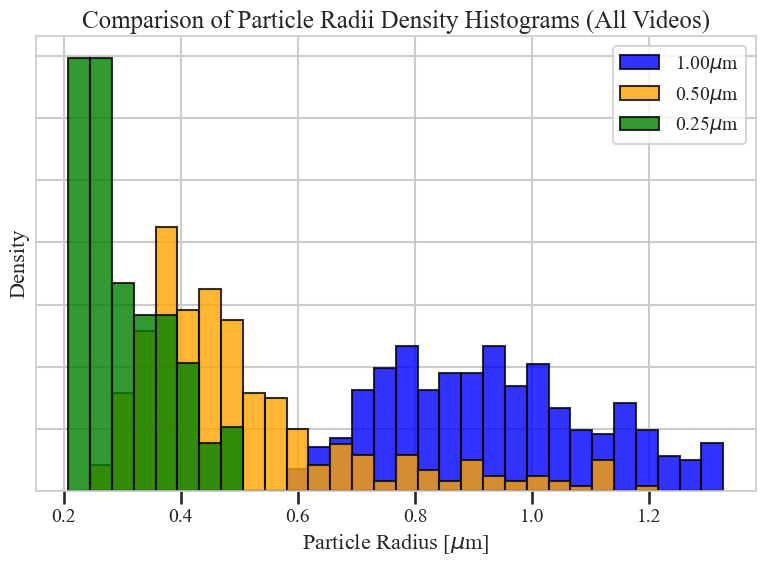

<Figure size 1000x500 with 0 Axes>

In [132]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gengamma, invgamma
import trackpy as tp

# ======================
# Physical Constants
# ======================
kb = 1.380649e-23       # J/K
T = 293.15              # K
eta = 1.002e-3          # Pa·s
d = 2                   # Dimensions (2D)
fps = 30

# Set Times New Roman font for all plot text
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

r_filtered_list = []
valid_labels = []
valid_colors = []
labels = [r'1.00$\mu$m', r'0.50$\mu$m', r'0.25$\mu$m']
colors = ['blue', 'orange', 'green']

for tm_i, label, color in zip([tm_2, tm_1, tm_0], labels, colors):
    tm = tm_i.reset_index(drop=True)  # Fix: reset index to avoid ambiguity
    particle_ids = tm['particle'].unique()
    print(f"{label}: {len(particle_ids)} unique particles")
    per_particle_r = []
    for pid in tqdm(particle_ids):
        traj = tm[tm['particle'] == pid]
        try:
            imsd = tp.imsd(traj, 0.0728, fps, 300)
            msd_vals = imsd.iloc[:, 0]
            lag_times = msd_vals.index.values
            mask = (msd_vals > 0) & (lag_times > 0)
            if mask.sum() < 3:
                continue
            log_tau = np.log10(lag_times[mask])
            log_msd = np.log10(msd_vals.values[mask])
            slope, intercept = np.polyfit(log_tau, log_msd, 1)
            A = 10**intercept
            if A <= 0:
                continue
            D_i = A / (2 * d) * 1e-12
            r_i = kb * T / (6 * np.pi * eta * D_i)
            per_particle_r.append(r_i * 1e6)
        except Exception as e:
            print(f"Error for particle {pid}: {e}")
            continue
    print(f"{label}: Found {len(per_particle_r)} radii before filtering")
    per_particle_r_um = np.array(per_particle_r)
    per_particle_r_um = per_particle_r_um[~np.isnan(per_particle_r_um)]
    if per_particle_r_um.size == 0:
        print(f"{label}: No valid radii after NaN removal.")
        continue
    # Use full range for filtering to avoid empty arrays
    r_0, r_100 = np.percentile(per_particle_r_um, [5, 95])
    mask_r = (per_particle_r_um >= r_0) & (per_particle_r_um <= r_100)
    r_filtered = per_particle_r_um[mask_r]
    print(f"{label}: {len(r_filtered)} radii after filtering")
    if r_filtered.size == 0:
        print(f"{label}: No valid radii after filtering.")
        continue
    r_filtered_list.append(r_filtered)
    valid_labels.append(label)
    valid_colors.append(color)

if len(r_filtered_list) == 0:
    print("No valid radii data found for any video.")
else:
    fig, ax = plt.subplots(figsize=(8, 6))
    all_r = np.concatenate(r_filtered_list)
    if all_r.size == 0:
        print("No data to plot.")
    else:
        r_min, r_max = np.percentile(all_r, [5, 95])
        bin_width = (r_max - r_min) / 30 if r_max > r_min else 1
        bins = np.arange(r_min, r_max + bin_width, bin_width)
        for r_filtered, label, color in zip(r_filtered_list, valid_labels, valid_colors):
            ax.hist(r_filtered, bins=bins, alpha=0.8, edgecolor='black', label=label, color=color, density=True)
        ax.set_xlabel(r'Particle Radius [$\mu$m]', fontname='Times New Roman')
        ax.set_ylabel('Density', fontname='Times New Roman')
        ax.set_title('Comparison of Particle Radii Density Histograms (All Videos)', fontname='Times New Roman')
        ax.legend(prop={'family': 'Times New Roman'})
        ax.grid(True)
        # Remove ticks except for bottom axis numbers
        ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
        ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
        plt.tight_layout()
        plt.show()
        plt.savefig('particle_radii_histograms.svg', format='svg', bbox_inches='tight', dpi=300)